In [1]:
from scipy.io.wavfile import read as read_wav
from IPython.display import Audio
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
import librosa as lr
import seaborn as sn
import pandas as pd
import numpy as np
import scipy
import pydub

In [2]:
genres = {
    'disco': 0,
    'country': 1,
    'jazz': 2,
    'classical': 3,
    'blues': 4,
    'hiphop': 5,
    'metal': 6,
    'rock': 7,
    'pop': 8,
    'reggae': 9
}

In [3]:
hparams = {
    'samplerate': 22050,
    'seq_length': 256,
    'hop_length': 512,
    'fft_window': 2048
}

In [4]:
def extract_features(filepath, hparams):
    
    audio_data_array = lr.load(filepath, sr=hparams['samplerate'], mono=True)
    
    # normalized = lr.util.normalize(audio_data_array[0])
    
    features = [
        
        # MFCC Features:
        lr.feature.mfcc(
            y          = audio_data_array[0],
            sr         = hparams['samplerate'],
            hop_length = hparams['hop_length'],
            n_fft      = hparams['fft_window']
        ),

        # Chroma STFT:
        lr.feature.chroma_stft(
            y          = audio_data_array[0],
            sr         = hparams['samplerate'],
            hop_length = hparams['hop_length'],
            n_fft      = hparams['fft_window']
        ),
        
        # Spectral Centroid:
        lr.feature.spectral_centroid(
            y          = audio_data_array[0],
            sr         = hparams['samplerate'],
            hop_length = hparams['hop_length'],
            n_fft      = hparams['fft_window']
        ),
        
        # Spectral Contrast:
        lr.feature.spectral_contrast(
            y          = audio_data_array[0],
            sr         = hparams['samplerate'],
            hop_length = hparams['hop_length'],
            n_fft      = hparams['fft_window']
        )
    ]
    
    return np.vstack(features)

In [5]:
lstm_1_model = tf.keras.models.load_model('LSTM-1/models/model')
lstm_2a_model = tf.keras.models.load_model('LSTM-2a/models/model')
lstm_2b_model = tf.keras.models.load_model('LSTM-2b/models/model')
lstm_3a_model = tf.keras.models.load_model('LSTM-3a/models/model')
lstm_3b_model = tf.keras.models.load_model('LSTM-3b/models/model')
lstm_3c_model = tf.keras.models.load_model('LSTM-3c/models/model')
lstm_3d_model = tf.keras.models.load_model('LSTM-3d/models/model')

In [6]:
def lookup(arr):
    if arr == [0, 0, 0]:
        return 'hiphop'
    elif arr == [0, 0, 1]:
        return 'metal'
    elif arr == [0, 0, 2]:
        return 'rock'
    elif arr == [0, 1, 0]:
        return 'pop'
    elif arr == [0, 1, 1]:
        return 'reggae'
    elif arr == [1, 0, 0]:
        return 'disco'
    elif arr == [1, 0, 1]:
        return 'country'
    elif arr == [1, 1, 0]:
        return 'jazz'
    elif arr == [1, 1, 1]:
        return 'classical'
    else:
        return 'blues'

In [7]:
def predict(features):
    
    result = []
    
    lstm_1_res = np.argmax(lstm_1_model.predict(features))
    # print('LSTM-1:', lstm_1_res)
    
    result += [lstm_1_res]
    
    # strong classes:
    if lstm_1_res == 0:
        
        lstm_2a_res = np.argmax(lstm_2a_model.predict(features))
        # print('LSTM-2a:', lstm_2a_res)
        
        result += [lstm_2a_res]
        
        # substrong-1:
        if lstm_2a_res == 0:
            
            lstm_3a_res = np.argmax(lstm_3a_model.predict(features))
            # print('LSTM-3a:', lstm_3a_res)
            
            result += [lstm_3a_res]
            
        # substrong-2:
        else:
            
            lstm_3b_res = np.argmax(lstm_3b_model.predict(features))
            # print('LSTM-3b:', lstm_3b_res)
            
            result += [lstm_3b_res]
            
    # mild classes:
    else:
        
        lstm_2b_res = np.argmax(lstm_2b_model.predict(features))
        # print('LSTM-2b:', lstm_2b_res)
        
        result += [lstm_2b_res]
        
        
        # submild-1:
        if lstm_2b_res == 0:
            
            lstm_3c_res = np.argmax(lstm_3c_model.predict(features))
            # print('LSTM-3c:', lstm_3c_res)
            
            result += [lstm_3c_res]
            
        # submild-2:
        else:
            
            lstm_3d_res = np.argmax(lstm_3d_model.predict(features))
            # print('LSTM-3d:', lstm_3d_res)
            
            result += [lstm_3d_res]
            
    return lookup(list(result))

### Accuracy on GTZAN Validation and Test Set:

In [8]:
processed = np.load('./prepared/processed.npy', allow_pickle=True)

### Top-1 Accuracy:

In [9]:
top_1_confusion_mat = np.zeros(shape=(10, 10))

In [10]:
ground_truth_labels = []

for i in range(0, 5000, 5):
    
    if (i % 500) >= 5 * 90:
        predicted = []
        for j in range(0, 5):
            if ((i+j) % 500) >= 5 * 90:
                predicted += [predict(processed[i+j]['features'].reshape(1, 256, 40))]
        
        original = processed[i]['ground_truth']
        
        top_1 = Counter(predicted).most_common(n=1)
        
        if original == top_1[0][0]:
            top_1_confusion_mat[genres[original]][genres[original]] += 1
        else:
            top_1_confusion_mat[genres[original]][genres[top_1[0][0]]] += 1
        
        ground_truth_labels += [original]
        
        # print('=========================================')
        # print('Original: {}'.format(original))
        # print('Predicted: {}'.format(top_1))

In [11]:
top_1_frame = pd.DataFrame(
    data=top_1_confusion_mat,
    index=list(genres.keys()),
    columns=list(genres.keys())
)

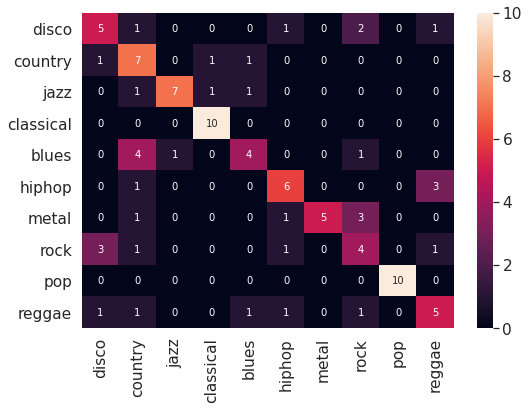

In [12]:
fig = plt.figure(figsize=(8, 6))

sn.set(font_scale=1.4) # for label size
sn.heatmap(top_1_frame, annot=True, annot_kws={"size": 10})

fig.tight_layout()
plt.show()

In [13]:
top_1_accuracy = 100 * (np.sum(np.diag(top_1_confusion_mat)) / np.sum(top_1_confusion_mat))
print('Top-1 Accuracy: {} %'.format(top_1_accuracy))

Top-1 Accuracy: 63.0 %


### Top-2 Accuracy:

In [14]:
top_2_confusion_mat = np.zeros(shape=(10, 10))

In [15]:
for i in range(0, 5000, 5):
    
    if (i % 500) >= 5 * 90:
        predicted = []
        for j in range(0, 5):
            if ((i+j) % 500) >= 5 * 90:
                predicted += [predict(processed[i+j]['features'].reshape(1, 256, 40))]
        
        original = processed[i]['ground_truth']
        
        top_2 = Counter(predicted).most_common(n=2)
        
        if original in [top_2[i][0] for i in range(len(top_2))]:
            top_2_confusion_mat[genres[original]][genres[original]] += 1
        else:
            for i in range(len(top_2)):
                top_2_confusion_mat[genres[original]][genres[top_2[i][0]]] += (1 / len(top_2))
        
        # print('=========================================')
        # print('Original: {}'.format(original))
        # print('Predicted: {}'.format(top_2))

In [16]:
top_2_frame = pd.DataFrame(
    data=top_2_confusion_mat,
    index=list(genres.keys()),
    columns=list(genres.keys())
)

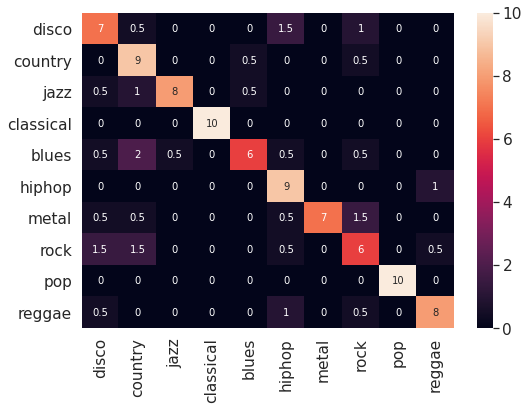

In [17]:
fig = plt.figure(figsize=(8, 6))

sn.set(font_scale=1.4) # for label size
sn.heatmap(top_2_frame, annot=True, annot_kws={"size": 10})

fig.tight_layout()
plt.show()

In [18]:
top_2_accuracy = 100 * (np.sum(np.diag(top_2_confusion_mat)) / np.sum(top_2_confusion_mat))
print('Top-2 Accuracy: {} %'.format(top_2_accuracy))

Top-2 Accuracy: 80.0 %
